## Model experiments with the 4-month collection period format

We currently have a model that uses 8 months of training data to generate predictions. We would like to experiment to see if a version of the model which trains on 4 months of user data to predict conversion in the following 2 month period could be viable. 

In [2]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from collections import Counter
from scipy.stats import uniform

from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassPredictionError


In [8]:
from matplotlib.colors import ListedColormap

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("classification-4month")

2024/05/03 17:23:42 INFO mlflow.tracking.fluent: Experiment with name 'classification-4month' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/495808822148702544', creation_time=1714771422795, experiment_id='495808822148702544', last_update_time=1714771422795, lifecycle_stage='active', name='classification-4month', tags={}>

#### Loading Data

In [4]:
train = pd.read_csv("/Users/aoluwolerotimi/Datasets/rr2/train_set.csv", index_col=0)
val = pd.read_csv("/Users/aoluwolerotimi/Datasets/rr2/val_set.csv", index_col=0)
test = pd.read_csv("/Users/aoluwolerotimi/Datasets/rr2/test_set.csv", index_col=0)

In [6]:
X_train = train.drop(columns=['fullVisitorId', 'targetConversion'])
y_train = train['targetConversion']
X_val = val.drop(columns=['fullVisitorId', 'targetConversion'])
y_val = val['targetConversion']
X_test = test.drop(columns=['fullVisitorId', 'targetConversion'])
y_test = test['targetConversion']

In [7]:
# deleting original dfs for memory
del train, val, test

#### Setting up functions originally defined by Conversion Data Scientists

In [9]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")

**Specific to mlflow**

In [ ]:
def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for name, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        preds = (probs >= threshold).astype(int)
        mlflow.log_metrics({
            f'{name}_accuracy': accuracy_score(y, preds),
            f'{name}_precision': precision_score(y, preds),
            f'{name}_recall': recall_score(y, preds),
            f'{name}_f1': f1_score(y, preds),
            f'{name}_roc_auc': roc_auc_score(y, probs)
        })

### Baseline Model: Logistic Regression

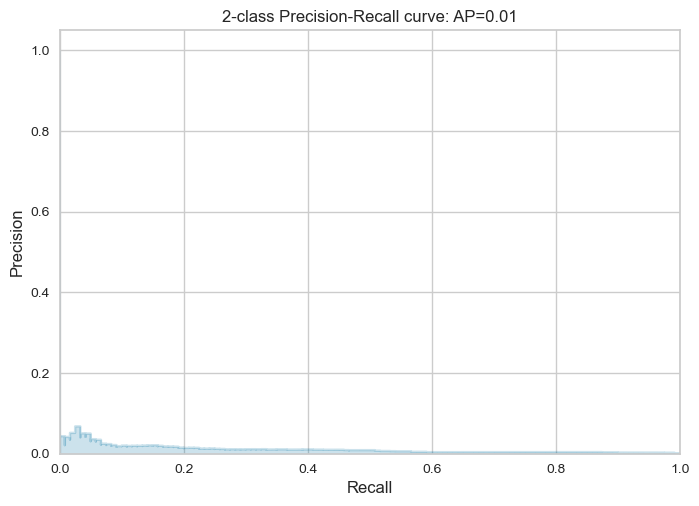

roc auc score: 0.8713150738516933



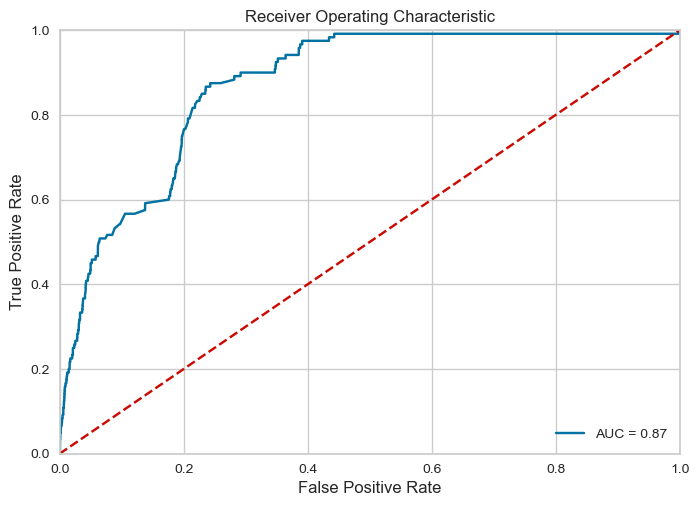

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    106091
           1       0.02      0.01      0.01       120

    accuracy                           1.00    106211
   macro avg       0.51      0.50      0.51    106211
weighted avg       1.00      1.00      1.00    106211


Confusion Matrix: 
 [[106047     44]
 [   119      1]]



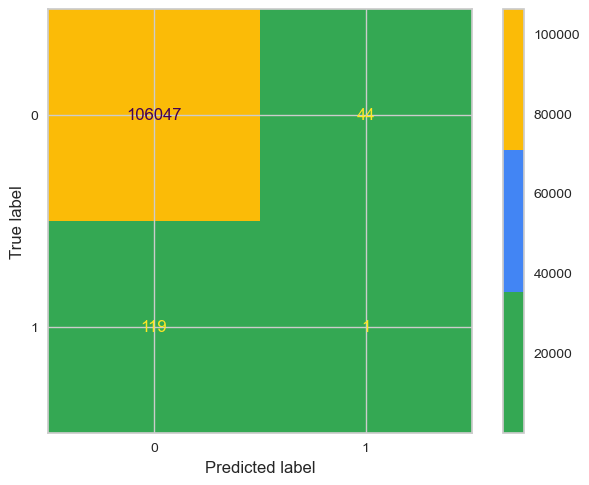

End of validation Result



In [10]:
logreg=LogisticRegression(max_iter=2000,random_state=42)
logreg.fit(X_train, y_train)
clf_score(logreg, X_train, y_train, X_val, y_val, train=False)

### Logging Replications of Tested Conversion Models with New Dataset Style

In [13]:
with mlflow.start_run(run_name="Logistic Regression Baseline"):
    
    # Define model parameters
    params = {
        'max_iter': 2000,
        'random_state': 42
    }

    # Initialize the Logistic Regression model with these parameters
    logreg1 = LogisticRegression(**params)

    # Train the model
    logreg1.fit(X_train, y_train)

    # Make predictions on a validation set
    y_pred = logreg1.predict(X_val)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='binary') 
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')

    # Log the model parameters
    mlflow.log_params(params)

    # Log the computed metrics
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)

In [14]:
with mlflow.start_run(run_name="Logistic Regression Balanced Class Weight"):
    
    # Define model parameters
    params = {
        'max_iter': 2000,
        'random_state': 42,
        'class_weight': 'balanced'
    }

    # Initialize the Logistic Regression model with these parameters
    logreg2 = LogisticRegression(**params)

    # Train the model
    logreg2.fit(X_train, y_train)

    # Make predictions on a validation set
    y_pred = logreg2.predict(X_val)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='binary')  
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')

    # Log the model parameters
    mlflow.log_params(params)

    # Log the computed metrics
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)

Slightly lower f1 but much better recall achieved with balanced class weights

n_estimators=100,max_depth=5, random_state=42, class_weight='balanced'

In [15]:
with mlflow.start_run(run_name="Random Forest Balanced Class Weight"):
    
    # Define model parameters
    params = {
        'n_estimators': 100,
        'random_state': 42,
        'class_weight': 'balanced',
        'max_depth': 5
    }

    # Initialize the model with these parameters
    rf = RandomForestClassifier(**params)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on a validation set
    y_pred = rf.predict(X_val)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='binary')  
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')

    # Log the model parameters
    mlflow.log_params(params)

    # Log the computed metrics
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)

Random forest provides the best f1score yet

In [16]:
from xgboost import XGBClassifier

In [17]:
with mlflow.start_run(run_name="XGBoost Balanced Class Weight"):
    
    # Define model parameters
    
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    
    params = {
        'n_estimators': 300,
        'random_state': 42,
        'scale_pos_weight': scale_pos_weight,
        'max_depth': 5
    }

    # Initialize the model with these parameters
    xgb = XGBClassifier(**params)

    # Train the model
    xgb.fit(X_train, y_train)

    # Make predictions on a validation set
    y_pred = xgb.predict(X_val)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='binary')  
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')

    # Log the model parameters
    mlflow.log_params(params)

    # Log the computed metrics
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)

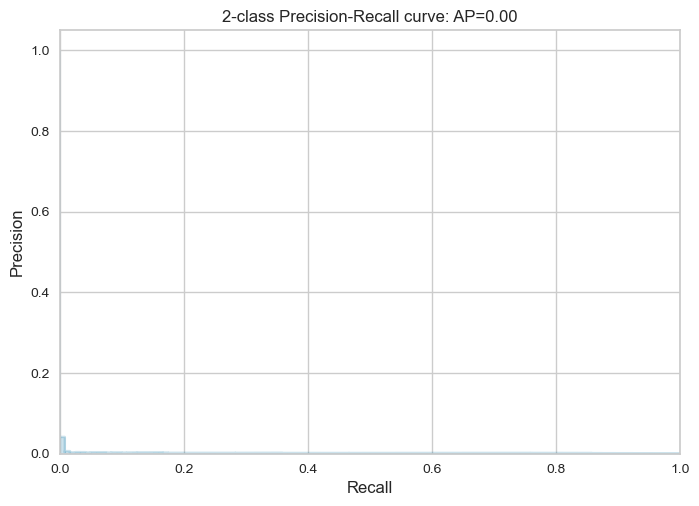

roc auc score: 0.6723068717736032



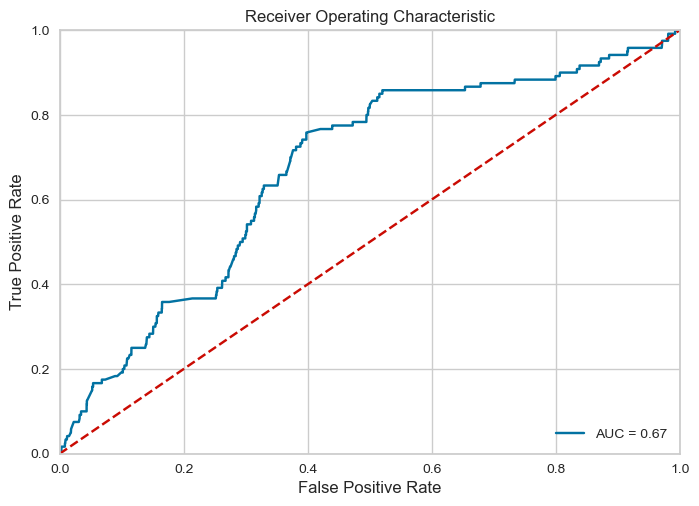

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    106091
           1       0.00      0.00      0.00       120

    accuracy                           1.00    106211
   macro avg       0.50      0.50      0.50    106211
weighted avg       1.00      1.00      1.00    106211


Confusion Matrix: 
 [[106091      0]
 [   120      0]]



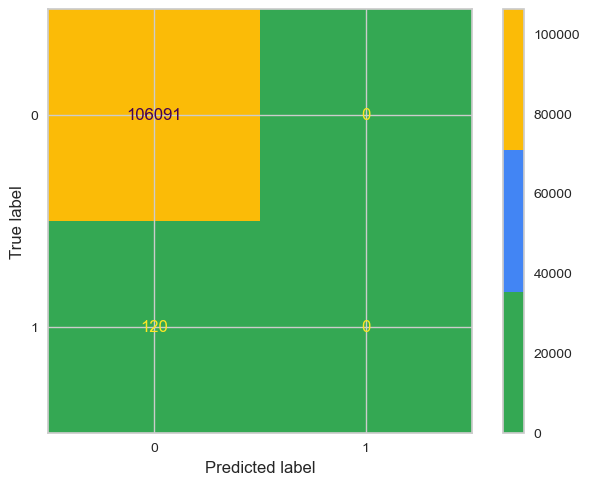

End of validation Result



In [18]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model=xgboost.XGBClassifier(n_estimators=300, max_depth=5, random_state=42,scale_pos_weight=scale_pos_weight)
xgb_model.fit(X_train, y_train)
clf_score(xgb_model, X_train, y_train, X_val, y_val, train=False)

XGBoost predicted all as 0 class. 

In [19]:
with mlflow.start_run(run_name="XGBoost"):
    
    # Define model parameters
    params = {
        'n_estimators': 300,
        'random_state': 42,
        'max_depth': 5
    }

    # Initialize the model with these parameters
    xgb2 = XGBClassifier(**params)

    # Train the model
    xgb2.fit(X_train, y_train)

    # Make predictions on a validation set
    y_pred = xgb2.predict(X_val)

    # Calculate metrics
    f1 = f1_score(y_val, y_pred, average='binary')  
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')

    # Log the model parameters
    mlflow.log_params(params)

    # Log the computed metrics
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)

Same results

With random forest showing some promise, will try some hyperparameter tuning on it with Optuna

### Optuna for Random Forest

In [22]:
import optuna

In [23]:
def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])

    # Set up the RandomForest classifier with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        class_weight=class_weight
    )
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_val)
    
    # Calculate the F1 score
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return f1


In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  

[I 2024-05-03 19:47:05,315] A new study created in memory with name: no-name-b468a2d6-b95d-46d4-a7e2-af26f37fba8d
[I 2024-05-03 19:47:09,986] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 53, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'auto', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.
[I 2024-05-03 19:47:17,905] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.
[I 2024-05-03 19:47:53,325] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 291, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'auto', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.0.
[I 2024-05-03 19:47:58,220] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 65, 'max_depth': 10, 'min_samples_

In [25]:
with mlflow.start_run(run_name="Optimized Random Forest"):
    
    # Best hyperparameters
    best_params = study.best_params

    rf_optimized = RandomForestClassifier(**best_params, random_state=42)
    rf_optimized.fit(X_train, y_train)
    
    y_pred_optimized = rf_optimized.predict(X_val)
    f1 = f1_score(y_val, y_pred_optimized, average='binary')
    precision = precision_score(y_val, y_pred_optimized, average='binary')
    recall = recall_score(y_val, y_pred_optimized, average='binary')

    mlflow.log_params(best_params)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)